# PatchCore Visualization

시각화 노트북:
1. Anomaly Heatmap (원본 + 오버레이)
2. ROC Curves (Image/Pixel AUROC)
3. 카테고리별 성능 표

In [1]:
import os
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from sklearn.metrics import roc_curve, auc
import pandas as pd

# Load configuration
from config import get_config

cfg = get_config()

# Configuration from config.py
DATA_PATH = cfg.data.root_path
RESULTS_PATH = cfg.eval.results_dir
CHECKPOINTS_PATH = cfg.train.checkpoint_dir
CATEGORIES = cfg.data.categories
IMAGE_SIZE = cfg.data.image_size

print(f"Configuration loaded:")
print(f"  Data path: {DATA_PATH}")
print(f"  Results path: {RESULTS_PATH}")
print(f"  Categories: {len(CATEGORIES)}")

Configuration loaded:
  Data path: /mnt/e/Big Data/MVTec AD
  Results path: ./results
  Categories: 15


## 1. Load Results

In [2]:
def load_results(results_path: str) -> dict:
    """Load evaluation results from summary.json"""
    summary_path = Path(results_path) / 'summary.json'
    
    if not summary_path.exists():
        print(f"Warning: {summary_path} not found")
        return None
    
    with open(summary_path, 'r') as f:
        return json.load(f)

def load_category_scores(results_path: str, category: str) -> dict:
    """Load per-image scores for a category"""
    scores_path = Path(results_path) / category / 'scores.json'
    
    if not scores_path.exists():
        return None
    
    with open(scores_path, 'r') as f:
        return json.load(f)

# Load summary
results = load_results(RESULTS_PATH)
if results:
    print(f"Loaded results for {len(results.get('categories', {}))} categories")
    print(f"Average Image AUROC: {results['average_image_auroc']*100:.1f}%")
    print(f"Average Pixel AUROC: {results['average_pixel_auroc']*100:.1f}%")

Loaded results for 15 categories
Average Image AUROC: 97.3%
Average Pixel AUROC: 97.1%


## 2. Category Performance Table

In [3]:
def create_performance_table(results: dict) -> pd.DataFrame:
    """Create a performance table for all categories"""
    if results is None:
        return None
    
    data = []
    for category in CATEGORIES:
        if category in results['categories']:
            cat_results = results['categories'][category]
            data.append({
                'Category': category,
                'Image AUROC (%)': cat_results.get('image_auroc', 0) * 100,
                'Pixel AUROC (%)': (cat_results.get('pixel_auroc') or 0) * 100,
                'Test Samples': cat_results.get('num_test_samples', 0),
                'Normal': cat_results.get('num_normal', 0),
                'Anomaly': cat_results.get('num_anomaly', 0),
                'FPS': cat_results.get('fps', 0)
            })
    
    df = pd.DataFrame(data)
    
    # Add average row
    avg_row = {
        'Category': 'AVERAGE',
        'Image AUROC (%)': df['Image AUROC (%)'].mean(),
        'Pixel AUROC (%)': df['Pixel AUROC (%)'].mean(),
        'Test Samples': df['Test Samples'].sum(),
        'Normal': df['Normal'].sum(),
        'Anomaly': df['Anomaly'].sum(),
        'FPS': df['FPS'].mean()
    }
    df = pd.concat([df, pd.DataFrame([avg_row])], ignore_index=True)
    
    return df

# Create and display table
if results:
    perf_table = create_performance_table(results)
    display(perf_table.style.format({
        'Image AUROC (%)': '{:.1f}',
        'Pixel AUROC (%)': '{:.1f}',
        'FPS': '{:.1f}'
    }).background_gradient(subset=['Image AUROC (%)', 'Pixel AUROC (%)'], cmap='RdYlGn', vmin=90, vmax=100))

,Category,Image AUROC (%),Pixel AUROC (%),Test Samples,Normal,Anomaly,FPS
0,bottle,100.0,98.0,83,20,63,3.5
1,cable,98.6,97.9,150,58,92,3.4
2,capsule,95.5,98.4,132,23,109,3.3
3,hazelnut,100.0,97.9,110,40,70,2.4
4,metal_nut,99.5,98.2,115,22,93,4.4
5,pill,94.3,97.2,167,26,141,3.8
6,screw,90.7,98.3,160,41,119,4.1
7,toothbrush,90.8,98.4,42,12,30,4.3
8,transistor,99.2,94.9,100,60,40,3.3
9,zipper,96.8,98.0,151,32,119,4.7


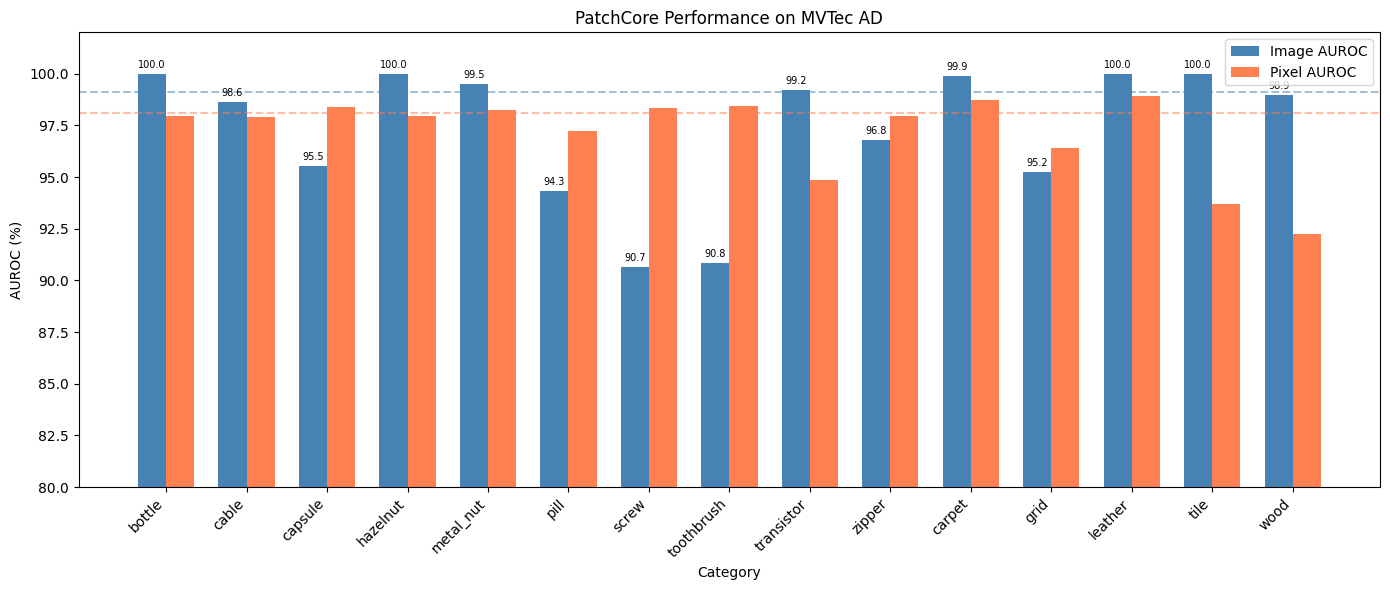

In [4]:
def plot_performance_bars(results: dict):
    """Plot bar chart of performance by category"""
    if results is None:
        print("No results to plot")
        return
    
    categories = []
    image_aurocs = []
    pixel_aurocs = []
    
    for cat in CATEGORIES:
        if cat in results['categories']:
            categories.append(cat)
            image_aurocs.append(results['categories'][cat].get('image_auroc', 0) * 100)
            pixel_aurocs.append((results['categories'][cat].get('pixel_auroc') or 0) * 100)
    
    x = np.arange(len(categories))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 6))
    bars1 = ax.bar(x - width/2, image_aurocs, width, label='Image AUROC', color='steelblue')
    bars2 = ax.bar(x + width/2, pixel_aurocs, width, label='Pixel AUROC', color='coral')
    
    ax.set_xlabel('Category')
    ax.set_ylabel('AUROC (%)')
    ax.set_title('PatchCore Performance on MVTec AD')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(80, 102)
    ax.axhline(y=99.1, color='steelblue', linestyle='--', alpha=0.5, label='Paper (Image)')
    ax.axhline(y=98.1, color='coral', linestyle='--', alpha=0.5, label='Paper (Pixel)')
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)
    
    plt.tight_layout()
    plt.savefig(Path(RESULTS_PATH) / 'performance_bars.png', dpi=150)
    plt.show()

plot_performance_bars(results)

## 3. ROC Curves

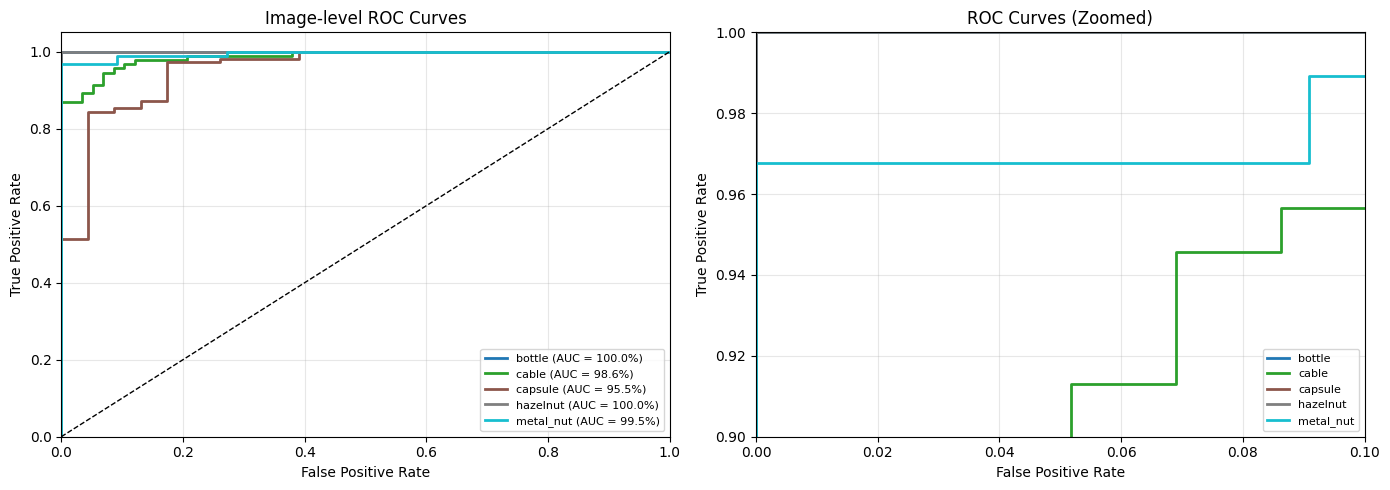

In [5]:
def plot_roc_curves(results_path: str, categories: list = None):
    """Plot ROC curves for selected categories"""
    if categories is None:
        categories = CATEGORIES[:5]  # Default: first 5 categories
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(categories)))
    
    for idx, category in enumerate(categories):
        scores_data = load_category_scores(results_path, category)
        if scores_data is None:
            continue
        
        scores = np.array(scores_data['scores'])
        labels = np.array(scores_data['labels'])
        
        # Image-level ROC
        fpr, tpr, _ = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        
        axes[0].plot(fpr, tpr, color=colors[idx], lw=2,
                     label=f'{category} (AUC = {roc_auc*100:.1f}%)')
    
    # Plot diagonal
    axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Image-level ROC Curves')
    axes[0].legend(loc='lower right', fontsize=8)
    axes[0].grid(True, alpha=0.3)
    
    # Zoom in on top-left corner
    axes[1].set_xlim([0.0, 0.1])
    axes[1].set_ylim([0.9, 1.0])
    
    for idx, category in enumerate(categories):
        scores_data = load_category_scores(results_path, category)
        if scores_data is None:
            continue
        
        scores = np.array(scores_data['scores'])
        labels = np.array(scores_data['labels'])
        
        fpr, tpr, _ = roc_curve(labels, scores)
        axes[1].plot(fpr, tpr, color=colors[idx], lw=2, label=category)
    
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curves (Zoomed)')
    axes[1].legend(loc='lower right', fontsize=8)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(Path(RESULTS_PATH) / 'roc_curves.png', dpi=150)
    plt.show()

# Plot ROC curves for first 5 categories
plot_roc_curves(RESULTS_PATH, CATEGORIES[:5])

## 4. Anomaly Heatmap Visualization

In [6]:
def visualize_anomaly_heatmap(
    image_path: str,
    anomaly_map: np.ndarray,
    mask: np.ndarray = None,
    score: float = None,
    title: str = None,
    alpha: float = 0.5
):
    """Visualize original image with anomaly heatmap overlay"""
    # Load original image (use IMAGE_SIZE from config)
    image = Image.open(image_path).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image_np = np.array(image)
    
    # Normalize anomaly map
    if anomaly_map.max() > anomaly_map.min():
        anomaly_norm = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())
    else:
        anomaly_norm = np.zeros_like(anomaly_map)
    
    # Create figure
    n_cols = 4 if mask is not None else 3
    fig, axes = plt.subplots(1, n_cols, figsize=(4*n_cols, 4))
    
    # Original image
    axes[0].imshow(image_np)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Anomaly heatmap
    im = axes[1].imshow(anomaly_norm, cmap='jet')
    axes[1].set_title('Anomaly Map')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Overlay
    axes[2].imshow(image_np)
    axes[2].imshow(anomaly_norm, cmap='jet', alpha=alpha)
    axes[2].set_title(f'Overlay (score: {score:.3f})' if score else 'Overlay')
    axes[2].axis('off')
    
    # Ground truth mask (if available)
    if mask is not None:
        axes[3].imshow(mask, cmap='gray')
        axes[3].set_title('Ground Truth')
        axes[3].axis('off')
    
    if title:
        fig.suptitle(title, fontsize=12)
    
    plt.tight_layout()
    return fig

def load_anomaly_map(results_path: str, category: str, image_name: str) -> np.ndarray:
    """Load saved anomaly map"""
    anomaly_path = Path(results_path) / category / 'anomaly_maps' / f"{image_name}_anomaly.npy"
    if anomaly_path.exists():
        return np.load(str(anomaly_path))
    return None

def load_ground_truth_mask(data_path: str, category: str, defect_type: str, image_name: str) -> np.ndarray:
    """Load ground truth mask"""
    mask_path = Path(data_path) / category / 'ground_truth' / defect_type / f"{image_name}_mask.png"
    if mask_path.exists():
        mask = Image.open(mask_path).convert('L')
        mask = mask.resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)
        return np.array(mask) / 255.0
    return None

In [7]:
def visualize_category_samples(
    data_path: str,
    results_path: str,
    category: str,
    num_samples: int = 3
):
    """Visualize sample anomaly detections for a category"""
    scores_data = load_category_scores(results_path, category)
    if scores_data is None:
        print(f"No scores found for {category}")
        return
    
    # Get anomaly samples with highest scores
    paths = scores_data['paths']
    scores = np.array(scores_data['scores'])
    labels = np.array(scores_data['labels'])
    
    # Find anomaly samples
    anomaly_indices = np.where(labels == 1)[0]
    if len(anomaly_indices) == 0:
        print(f"No anomaly samples found for {category}")
        return
    
    # Sort by score and take top samples
    anomaly_scores = scores[anomaly_indices]
    sorted_indices = np.argsort(anomaly_scores)[::-1][:num_samples]
    
    print(f"\nTop {num_samples} anomaly detections for {category}:")
    print("="*60)
    
    for i, idx in enumerate(sorted_indices):
        sample_idx = anomaly_indices[idx]
        image_path = paths[sample_idx]
        score = scores[sample_idx]
        
        # Get image name and defect type
        path_parts = Path(image_path).parts
        image_name = Path(image_path).stem
        defect_type = path_parts[-2]  # e.g., 'broken_large'
        
        # Load anomaly map
        anomaly_map = load_anomaly_map(results_path, category, image_name)
        if anomaly_map is None:
            print(f"  Anomaly map not found for {image_name}")
            continue
        
        # Load ground truth mask
        mask = load_ground_truth_mask(data_path, category, defect_type, image_name)
        
        # Visualize
        fig = visualize_anomaly_heatmap(
            image_path=image_path,
            anomaly_map=anomaly_map,
            mask=mask,
            score=score,
            title=f"{category} / {defect_type} / {image_name}"
        )
        
        # Save figure
        save_path = Path(results_path) / category / f'visualization_{i+1}.png'
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        
        plt.show()
        print(f"  Saved: {save_path}")


Top 3 anomaly detections for bottle:


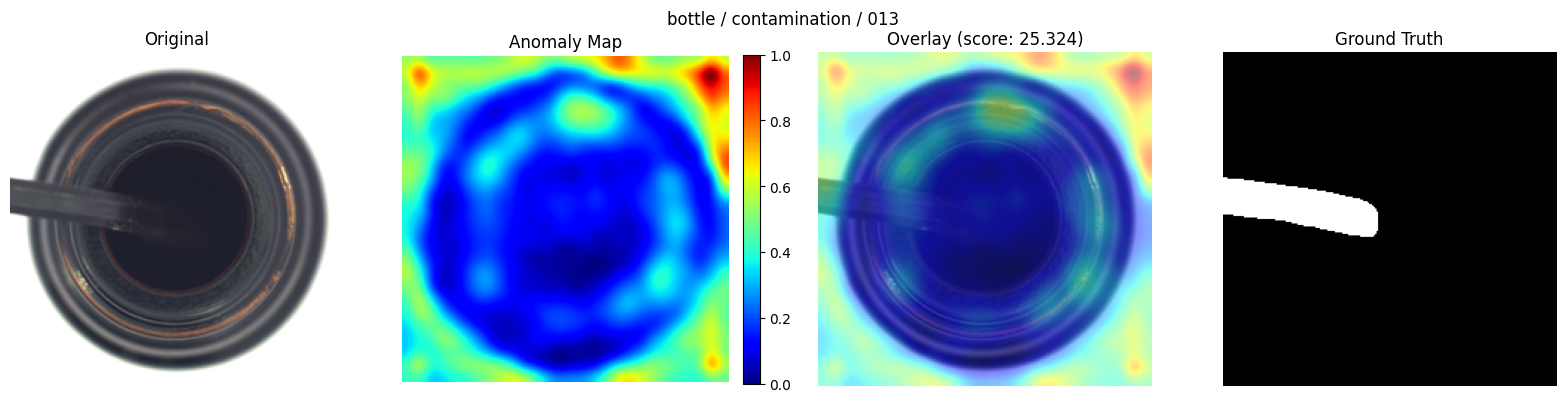

  Saved: results/bottle/visualization_1.png


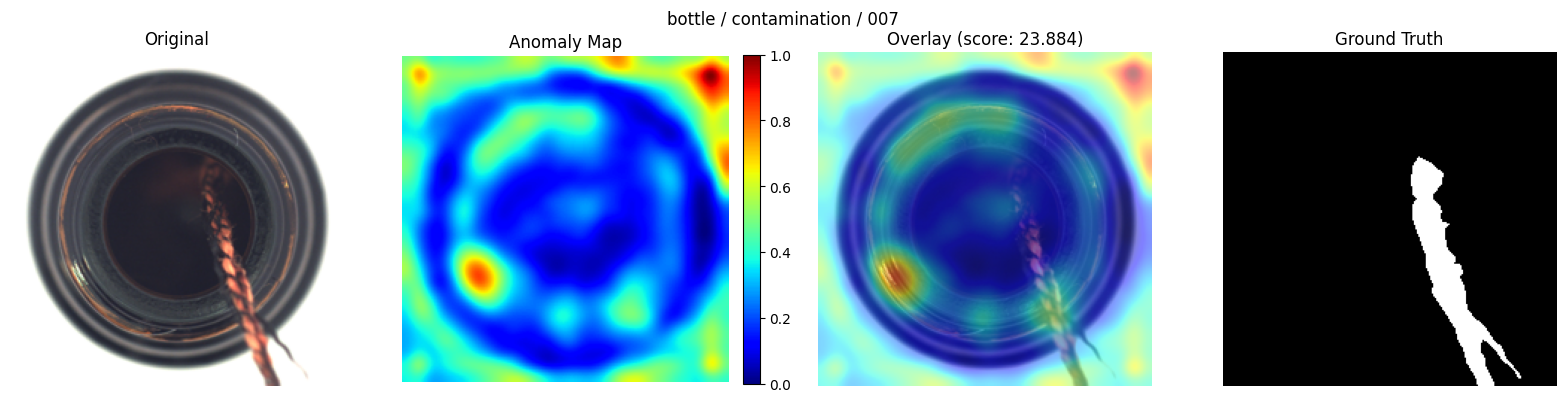

  Saved: results/bottle/visualization_2.png


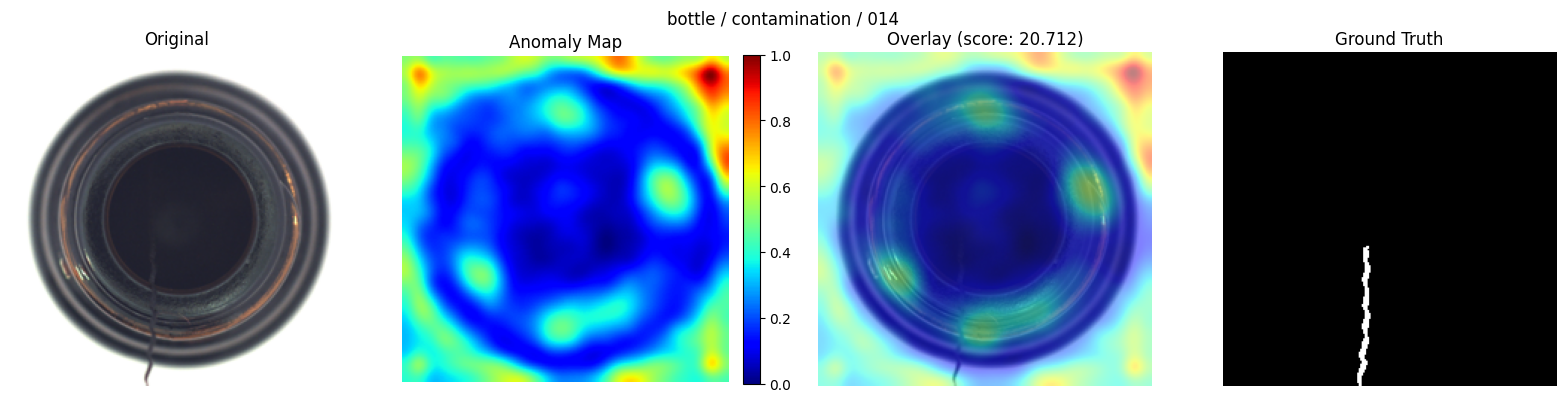

  Saved: results/bottle/visualization_3.png


In [8]:
# Visualize samples for a specific category
SELECTED_CATEGORY = 'bottle'  # Change this to visualize different categories

visualize_category_samples(
    data_path=DATA_PATH,
    results_path=RESULTS_PATH,
    category=SELECTED_CATEGORY,
    num_samples=3
)

## 5. Compare Normal vs Anomaly Score Distributions

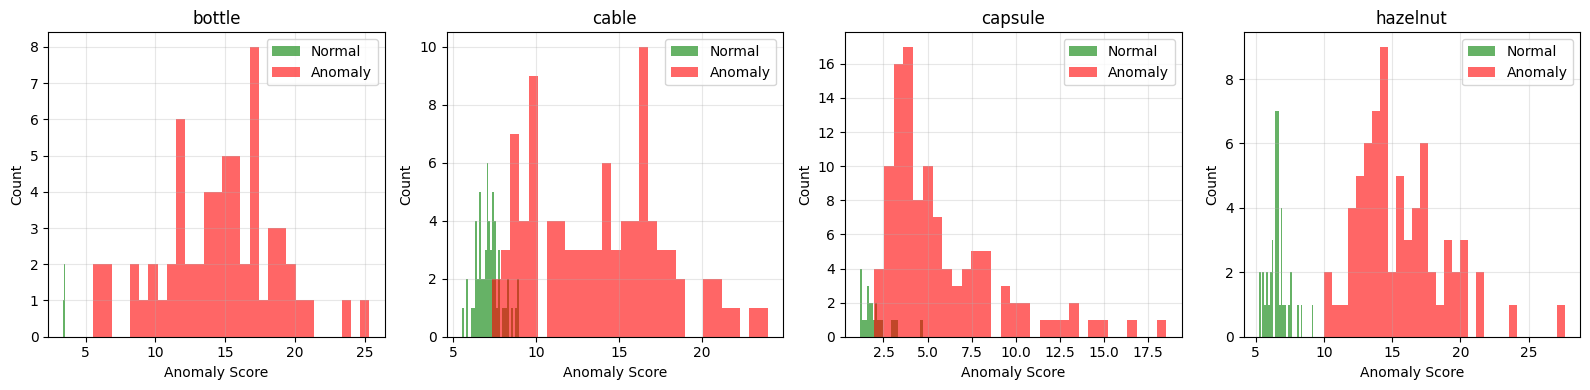

In [9]:
def plot_score_distributions(results_path: str, categories: list = None):
    """Plot score distributions for normal vs anomaly samples"""
    if categories is None:
        categories = CATEGORIES[:4]
    
    n_cats = len(categories)
    fig, axes = plt.subplots(1, n_cats, figsize=(4*n_cats, 4))
    
    if n_cats == 1:
        axes = [axes]
    
    for ax, category in zip(axes, categories):
        scores_data = load_category_scores(results_path, category)
        if scores_data is None:
            continue
        
        scores = np.array(scores_data['scores'])
        labels = np.array(scores_data['labels'])
        
        normal_scores = scores[labels == 0]
        anomaly_scores = scores[labels == 1]
        
        ax.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='green')
        ax.hist(anomaly_scores, bins=30, alpha=0.6, label='Anomaly', color='red')
        
        ax.set_xlabel('Anomaly Score')
        ax.set_ylabel('Count')
        ax.set_title(category)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(Path(RESULTS_PATH) / 'score_distributions.png', dpi=150)
    plt.show()

plot_score_distributions(RESULTS_PATH, CATEGORIES[:4])

## 6. Summary Statistics

In [10]:
def print_summary_statistics(results: dict):
    """Print summary statistics"""
    if results is None:
        print("No results loaded")
        return
    
    print("="*60)
    print("PATCHCORE EVALUATION SUMMARY")
    print("="*60)
    
    # Overall performance
    print(f"\nOverall Performance:")
    print(f"  Average Image AUROC: {results['average_image_auroc']*100:.2f}%")
    print(f"  Average Pixel AUROC: {results['average_pixel_auroc']*100:.2f}%")
    
    # Best and worst categories
    image_aurocs = {cat: r['image_auroc'] for cat, r in results['categories'].items() if 'image_auroc' in r}
    
    if image_aurocs:
        best_cat = max(image_aurocs, key=image_aurocs.get)
        worst_cat = min(image_aurocs, key=image_aurocs.get)
        
        print(f"\nBest Category:  {best_cat} ({image_aurocs[best_cat]*100:.2f}%)")
        print(f"Worst Category: {worst_cat} ({image_aurocs[worst_cat]*100:.2f}%)")
    
    # Timing
    print(f"\nTiming:")
    print(f"  Total evaluation time: {results.get('total_time', 0)/60:.1f} minutes")
    
    # Categories meeting target
    target_image = 0.99  # 99% target
    meeting_target = sum(1 for v in image_aurocs.values() if v >= target_image)
    print(f"\nCategories meeting 99% Image AUROC: {meeting_target}/{len(image_aurocs)}")
    
    print("="*60)

print_summary_statistics(results)

PATCHCORE EVALUATION SUMMARY

Overall Performance:
  Average Image AUROC: 97.30%
  Average Pixel AUROC: 97.14%

Best Category:  bottle (100.00%)
Worst Category: screw (90.65%)

Timing:
  Total evaluation time: 9.6 minutes

Categories meeting 99% Image AUROC: 7/15


## 7. Interactive Visualization (Optional)

In [11]:
# Interactive widget for exploring results (requires ipywidgets)
try:
    from ipywidgets import interact, Dropdown
    
    @interact(category=Dropdown(options=CATEGORIES, value='bottle'))
    def show_category(category):
        visualize_category_samples(
            data_path=DATA_PATH,
            results_path=RESULTS_PATH,
            category=category,
            num_samples=2
        )
except ImportError:
    print("ipywidgets not installed. Run: pip install ipywidgets")

interactive(children=(Dropdown(description='category', options=('bottle', 'cable', 'capsule', 'hazelnut', 'met…